# Validating a channel model IV curve with data from an experiment

In [8]:
# Imports and preliminaries.  
%matplotlib inline
import os
import sys

import django
import numpy as np
import quantities as pq
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16, 'lines.linewidth':3})

In [9]:
import owtests
from channelworm.fitter.initiators import Initiator
from neuronunit.tests.channel import IVCurvePeakTest
from neuronunit.models.channel import ChannelModel

In [10]:
# Setup access to the Django database
os.environ.setdefault(
    "DJANGO_SETTINGS_MODULE",
    "channelworm.web_app.settings"
)
django.setup()
from channelworm.ion_channel.models import GraphData

## Compare the IV curve predicted from the channel model to that observed from the data

In [11]:
# Instantiate the model
channel_model_name = 'EGL-19.channel'
channel_id = 'ca_boyle'
channel_file_path = os.path.join(owtests.CW_HOME,'models','%s.nml' % channel_model_name)
model_name = channel_model_name.split('.')[0]

model = ChannelModel(channel_file_path,channel_index=0,name=model_name)

In [12]:
# Get the experiment data from ChannelWorm and instantiate the test
doi = '10.1083/jcb.200203055' # The DOI of the paper containing the data
fig = '2B' # The figure and panel of the data
sample_data = GraphData.objects.get(graph__experiment__reference__doi=doi, 
                                    graph__figure_ref_address=fig)
obs = list(zip(*sample_data.asarray())) 
observation = {'i/C':obs[1]*pq.A/pq.F, 'v':obs[0]*pq.mV}
cell_capacitance = 1e-13 * pq.F # Capacitance is arbitrary if IV curves are scaled.  
observation['i'] = observation['i/C']*cell_capacitance

test = IVCurvePeakTest(observation, scale=True)

In [13]:
# Judge the model output against the experimental data
score = test.judge(model)
score.summarize()
print("The score was computed according to '%s' with raw value %s and pass cutoff %s" \
    % (score.description,score.raw,test.converter.cutoff))
print('The scaling factor for the model IV curve was %.3g' % score.related_data['scale_factor'])

pyNeuroML >>> Reloading data specified in LEMS file: /Users/rick/Dropbox (ASU)/dev/openworm/tests/owtests/ChannelWorm/LEMS_Test_ca_boyle.xml (/Users/rick/Dropbox (ASU)/dev/openworm/tests/owtests/ChannelWorm/LEMS_Test_ca_boyle.xml), base_dir: ., cwd: /Users/rick/Dropbox (ASU)/dev/openworm/tests/owtests/ChannelWorm


The score was computed according to 'The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.' with raw value 3.06 pA**2 and pass cutoff 1.0 pA**2
The scaling factor for the model IV curve was 0.929


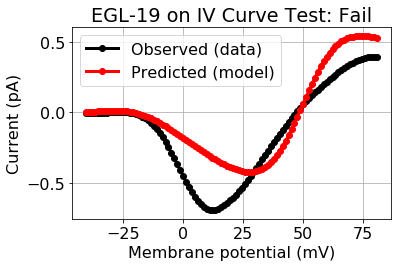

In [15]:
score.plot()
plt.tight_layout()
plt.savefig('/Users/rgerkin/Desktop/iv_curves.eps',format='eps')

In [22]:
# Cleanup
os.system('rm *.dat; rm *.xml')

0